Camera calibration from chessboard then applying that into the road image 

Next thing is to discover the bird view (aka perspective transform) into the road image. That requires marking the area of interest and 4 points of the images. 

lane curvature by using masking and thersholding techniques. 
Then birdviews to fit a polynomial to the lane lines. 
Extract the curvature lines from this polynomials left and right lane:using this formula: f(y) = Ay^2 + By + C, where A, B, and C are coefficients.
perspective transform on the z coordinate, or distance from the camera, the smaller it will appear in a 2D image. 
* This helps us to match a car's location directly
Compute the perspective transform, M, given source and destination points:


RGB vs HSV vs HLS: from the previous lesson, yellow lane are harder to detect, yet HLS represent different ways to measure the lightness and value. 
H and S stay stable under shadow or exesscive brightness that will be more reliable than RGB 


To do :

#sliding windows and ployfit 


#Detect lane pixels and fit to find the lane boundary.
#Determine the curvature of the lane and vehicle position with respect to center.
#Warp the detected lane boundaries back onto the original image.
#Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.





In [11]:
import os
import numpy as np
import cv2
import glob
import matplotlib
#matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

#out_dir='output_images/stage0/'
# Make a list of calibration images
#images = glob.glob('camera_cal/calibration*.jpg')

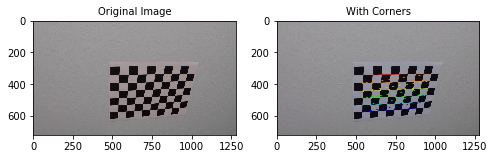

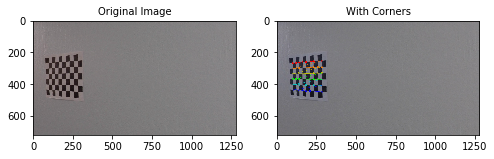

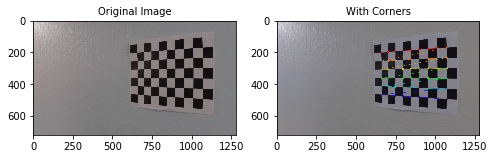

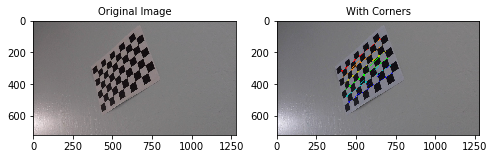

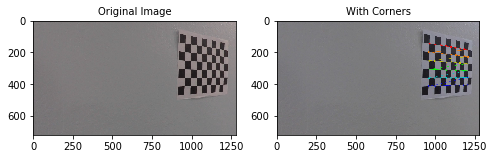

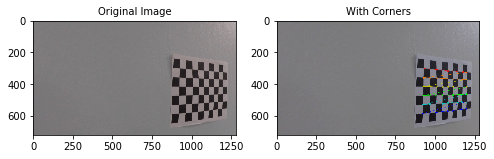

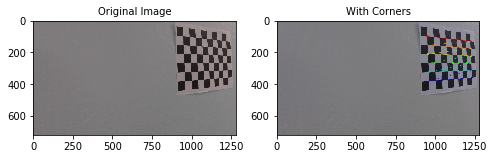

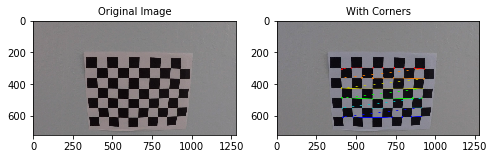

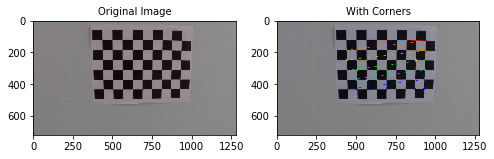

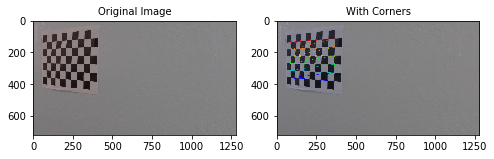

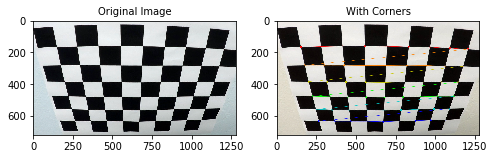

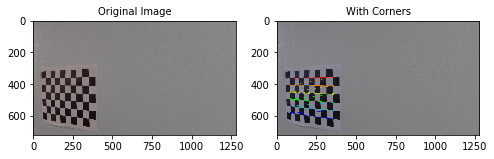

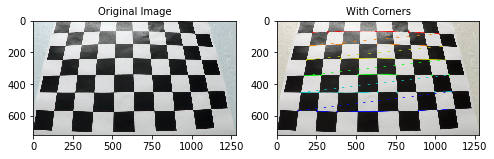

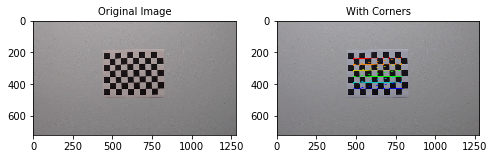

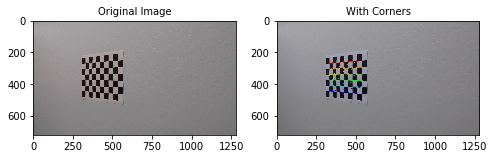

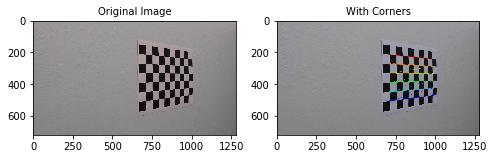

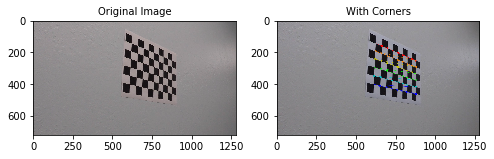

In [73]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=10)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=10)

In [70]:
 print(objp.shape)
print(corners.shape)

(54, 3)
(54, 1, 2)


Applying undistortion and see how does it fits on the images 

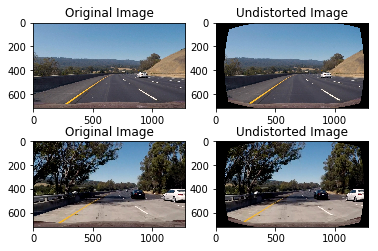

In [15]:
img = cv2.imread("test_images/test3.jpg")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
img_size = (img.shape[1], img.shape[0])
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.undistort(imgRGB, mtx, dist, None, mtx)
plt.subplot(2,2,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)

plt.subplot(2,2,2)
plt.title('Undistorted Image')
fig =plt.imshow(img2)


img = cv2.imread("test_images/test5.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.undistort(imgRGB, mtx, dist, None, mtx)

plt.subplot(2,2,3)
plt.title('Original Image')
fig =plt.imshow(imgRGB)

plt.subplot(2,2,4)
plt.title('Undistorted Image')
fig =plt.imshow(img2)

After applying calibration from cheeseboard, applying into the test image and see the difference between distorted and undistorted image. 
Birdview is the next thing to work on and applying them across all images 

In [177]:
def undistort(img):
    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)              
    return undist


def bird_eye(img):
    undist = undistort(img)
    img_size = (undist.shape[1], undist.shape[0])
    #src are the positions of 4 points in the original image that should form a regatangular shape
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    #dst points is the positions of those 4 src points after the perspective transform.
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    #undistorted and plotting the four points 
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    for i in range(4):
        ax1.plot(src[i][0],src[i][1],'rs') 
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=20)

    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    for i in range(4):
        ax2.plot(dst[i][0],dst[i][1],'rs')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return warped, M 

Plotting across all the images and see how does the birdviews across all images 

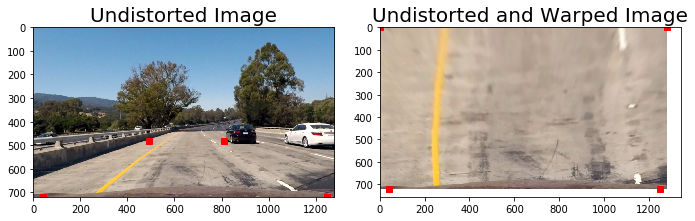

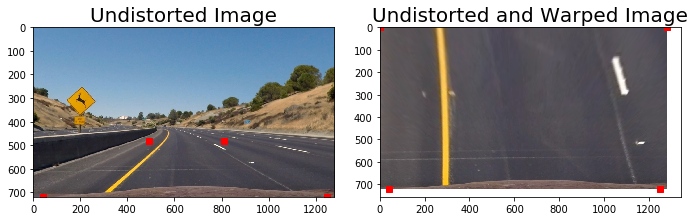

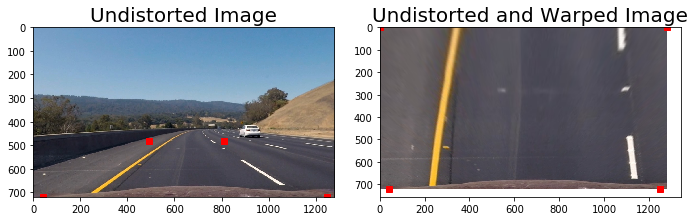

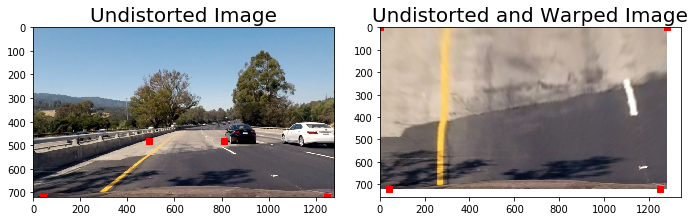

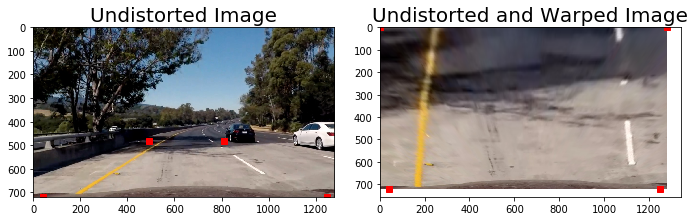

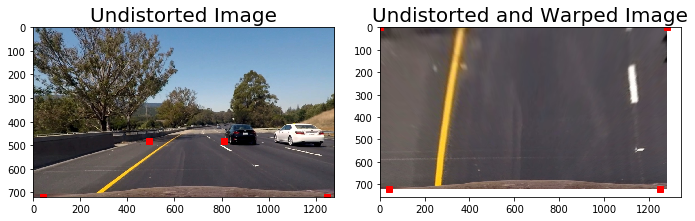

In [178]:
for image in glob.glob('test_images/test*.jpg'):
    bird_eye(image)

The visualization on the left and having the image warped on the right size. The images are actually is pretty good. 

Next is the find out the detect the lane from it and also calculate the distance. 

Prior knowing sobel and gradients would given a harder time to detect with the shadows. Therefore, I would applying different methods instead.

With an more advanced approach other than RBG , few more methods are introduced, given the fact that yellow lanes are harder to detect. 

New methods are introduced: 
1.HLS(hue,saturation, lightness) represent different ways to measure the lightness and value. 
2.HSV (hue, saturation, value) has to do with the 'actual color" 

HLS vs HSV
H and S stay stable under shadow or excesive brightness that will be more reliable than RGB

L channel from LUV does well on white lane detection and not so great on the yellow lane. Whereas, B channel from LAB color space does a better job on yellow lane detection than S channel from HLS which is able to detect both white and yellow yet not perfect. 

The most effective way would be taken those 3 channels and stack them over

BLS would be those selected channels 

https://www.quora.com/What-exactly-is-HSV-What-does-an-HSV-version-of-an-RGB-image-represent



In [179]:
# Create binary thresholded images to isolate lane line pixels# Create 
def apply_thresholds(img):
    img, M = bird_eye(img)

    #with the help of OpenCV. it would be as simple as one liner 
    #converting each of them into their channel
    B = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2] 
    L = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    S = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    #apply thershold to theirs accordingly 

    B_bin = np.zeros_like(B)
    B_bin[(B >= 155) & (B <= 200)] = 1
    
    L_bin = np.zeros_like(L)
    L_bin[(L >= 225) & (L <= 255)] = 1    
   
    S_bin = np.zeros_like(S)
    S_bin[(S >= 180) & (S <= 255)] = 1
        
    #stack them over 
    Stacked = np.zeros_like(S_bin)
    Stacked[(L_bin == 1) | (B_bin == 1)] = 1    
    
    
    #plotting the images 
    f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
    f.tight_layout()
        
    ax1.set_title('Original Image', fontsize=16)
    ax1.imshow(cv2.cvtColor(undistort(image),cv2.COLOR_BGR2RGB))
        
    ax2.set_title('Warped Image', fontsize=16)
    ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

    ax3.set_title('b binary threshold', fontsize=16)
    ax3.imshow(B, cmap='gray')
    
    ax4.set_title('l binary threshold', fontsize=16)
    ax4.imshow(L, cmap='gray')  

    ax3.set_title('s binary threshold', fontsize=16)
    ax5.imshow(S, cmap='gray')

    ax6.set_title('Combined color thresholds', fontsize=16)
    ax6.imshow(Stacked, cmap='gray')

    return Stacked

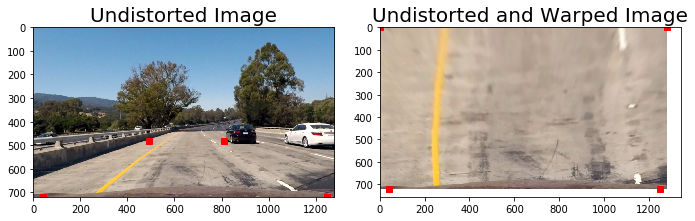

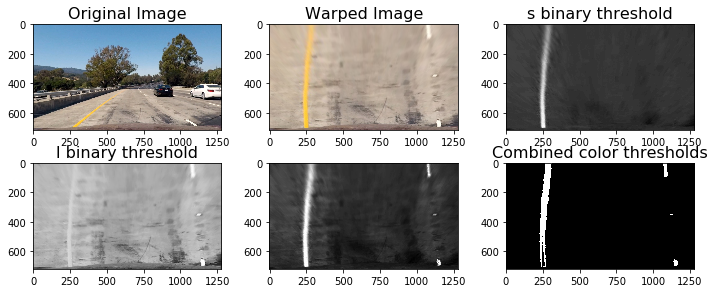

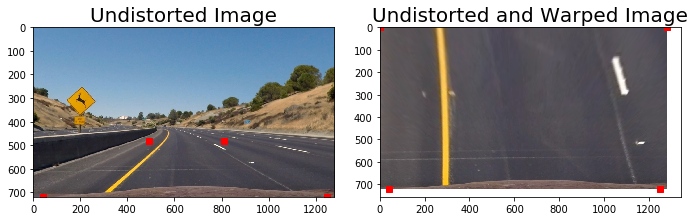

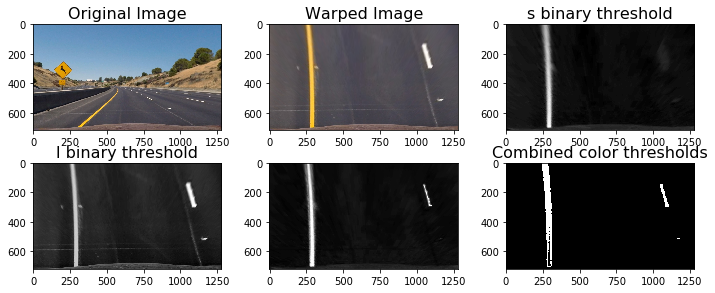

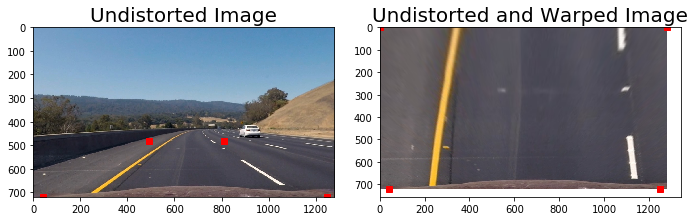

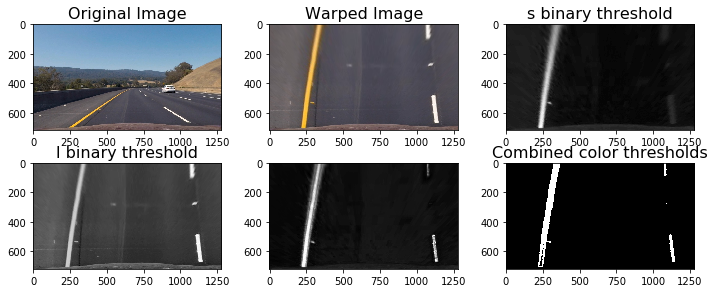

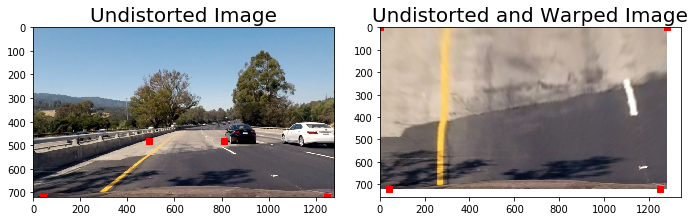

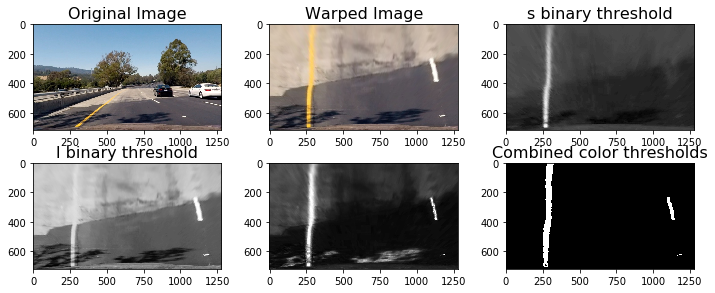

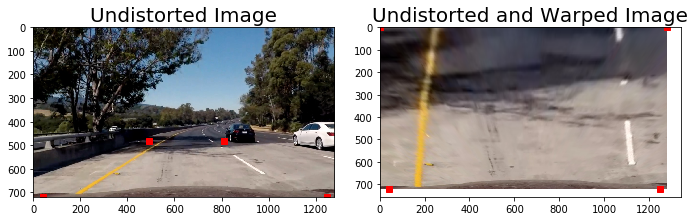

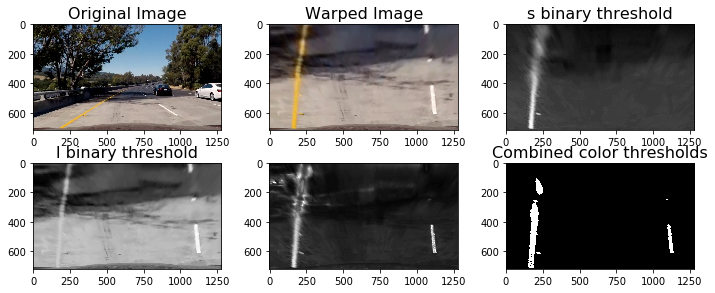

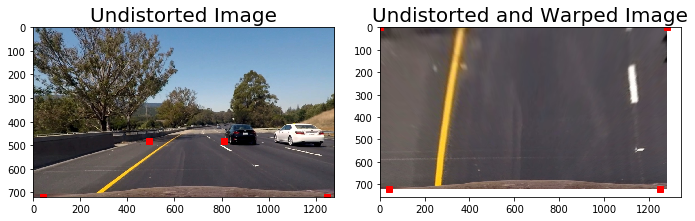

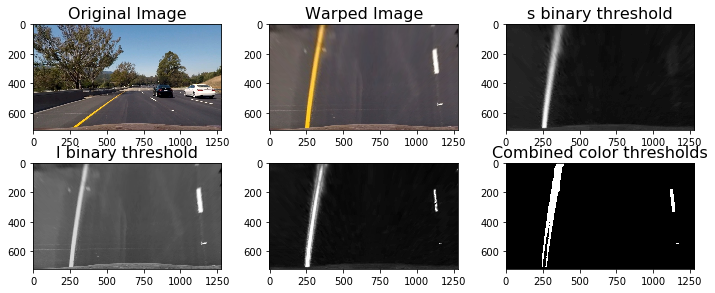

In [180]:
for image in glob.glob('test_images/test*.jpg'):
    apply_thresholds(image)

...


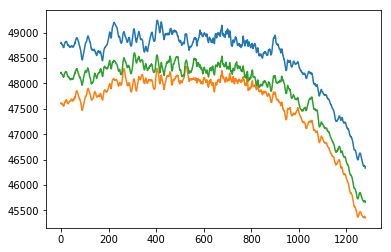

In [183]:
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)
plt.xlim(0, 1280)
print('...')

In [ ]:
#  polynomial, distance and curvation 
#converted from pixels to meters) is your distance from the center of the lane.


#finding the distance from window slicing 

